<a href="https://colab.research.google.com/github/uofg-iom/CNN_development/blob/normalised_images/cnn_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/uofg-iom/CNN_development.git

Cloning into 'CNN_development'...
remote: Enumerating objects: 2502, done.
remote: Counting objects: 100% (902/902), done.
remote: Compressing objects: 100% (859/859), done.
remote: Total 2502 (delta 47), reused 884 (delta 43), pack-reused 1600
Receiving objects: 100% (2502/2502), 130.15 MiB | 10.99 MiB/s, done.
Resolving deltas: 100% (641/641), done.


In [3]:
%ls
!cd .
! git status
! git pull

CNN_development/  sample_data/
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [25]:
!git status

On branch normalised_images
Your branch is up to date with 'origin/normalised_images'.

nothing to commit, working tree clean


In [5]:
%cd /content/CNN_development
!git status
!git checkout normalised_images

/content/CNN_development
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Branch 'normalised_images' set up to track remote branch 'normalised_images' from 'origin'.
Switched to a new branch 'normalised_images'


# Introductory work on CNN development

Sources:
* Main guide: https://keras.io/getting_started/intro_to_keras_for_engineers/
* Augmentation layers: https://keras.io/api/layers/preprocessing_layers/image_augmentation/
* Image classification example: https://keras.io/examples/vision/image_classification_from_scratch/



In [6]:
import numpy as np
import tensorflow as tf
# from tensorflow import keras
from matplotlib import pyplot as plt


# Data Augmentation layer can take place as a model layer (synchronous)
# or to the dataset (asynchronously) before being passed to the model
# The synchronous option benefits from GPU acceleration, however it will be slower when run on a CPU
# The asynchronous option is better if we are training on a CPU

SYNCHRONOUS_AUGM = True
dataset_path = "train_dataset"

# Load dataset

In [7]:
# Load dataset as TensorFlow Dataset Object
# Shuffle argument shuffles all images in all classes and places them into batches
# If shuffle is false, then the data is placed into batches based on the order in which they are loaded 
# Image size downsizes the image to the specified resolution, it doesn't crop
# If crop_to_aspect_ratio is selected then the image is cropped
rescale_image_size = (128,128)
ds_batch_size = 16

train_ds, val_ds  = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    batch_size=ds_batch_size,
    image_size=rescale_image_size,
    crop_to_aspect_ratio=False,
    color_mode='rgb',
    shuffle=True,
    seed=100)

class_names = train_ds.class_names
print(class_names)

# For demonstration, iterate over the batches yielded by the dataset.
# for data, labels in train_ds:
#    print(data.shape)  # (64, 200, 200, 3)
#    print(data.dtype)  # float32
#    print(labels.shape)  # (64,)
#    print(labels.dtype)  # int32


 
sel_batch = 6
num_rows = 3
num_cols = 3
            
# plt.figure(figsize=(10, 10))
# # .take() selects the batch number to show
# for images, labels in train_ds.take(sel_batch):
#     for i in range(num_rows*num_cols):
#         ax = plt.subplot(num_rows, num_cols, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.tight_layout()
#         # plt.axis("off")

Found 562 files belonging to 5 classes.
Using 450 files for training.
Using 112 files for validation.
['acne', 'dry', 'normal', 'oily', 'wrinkles']


# Create artificial images to increase dataset size

Apply image transformations (flip, rotate)

# Image Preprocessing

Keras comes with preprocessing layers to aid with resizing, cropping, normalization etc.

Good to use those so that model accepts raw data (RGB [0,255]) and performs all the preprocessing directly without external API dependencies.

Pre-processing can take place before training or during training.

In [8]:
# "Filters" to be applied sequentially to each image
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        # tf.keras.layers.RandomCrop(200, 200),
        tf.keras.layers.RandomBrightness(0.1),
        tf.keras.layers.RandomContrast(0.2), # Computationally expensive
        # tf.keras.layers.RandomZoom(0.2, 0.2) # Computationally expensive
        # tf.keras.layers.RandomTranslation(height_factor= 0.2, width_factor= 0.2, fill_mode="nearest") # Perhaps too much for this application
    ]
)


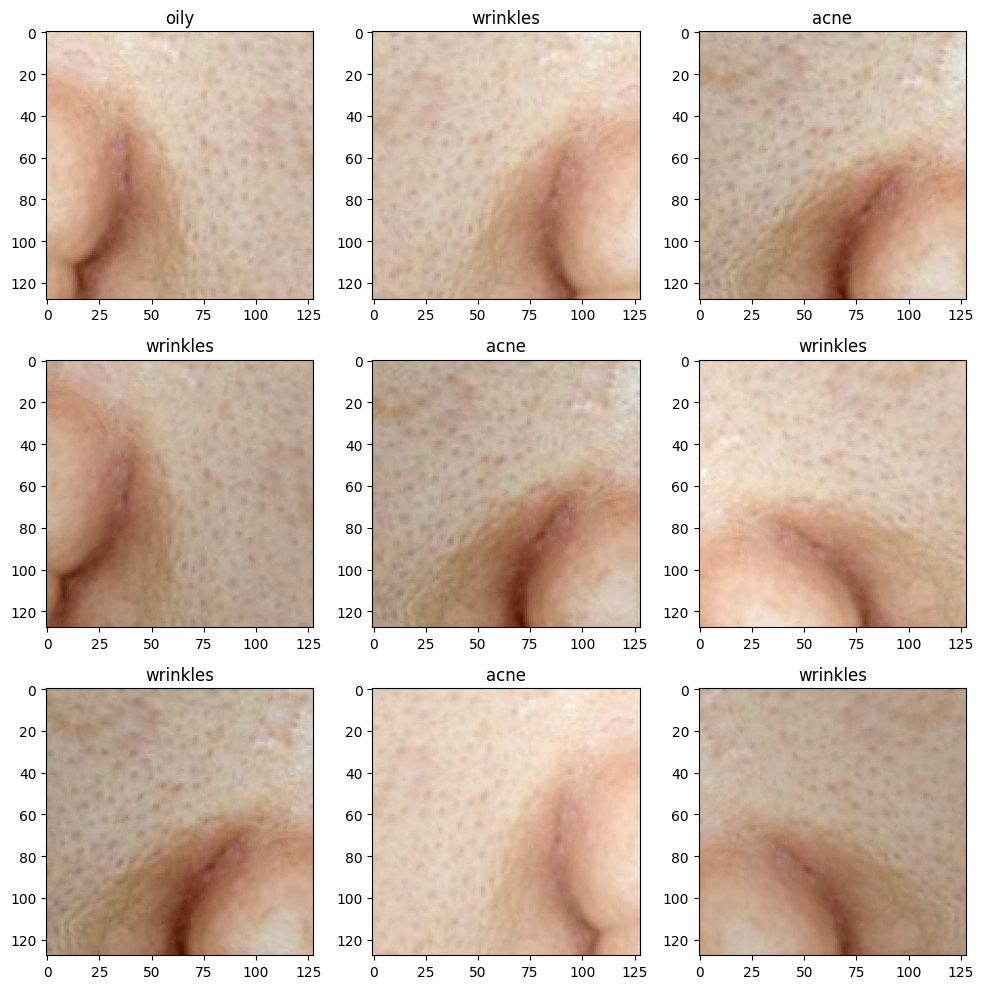

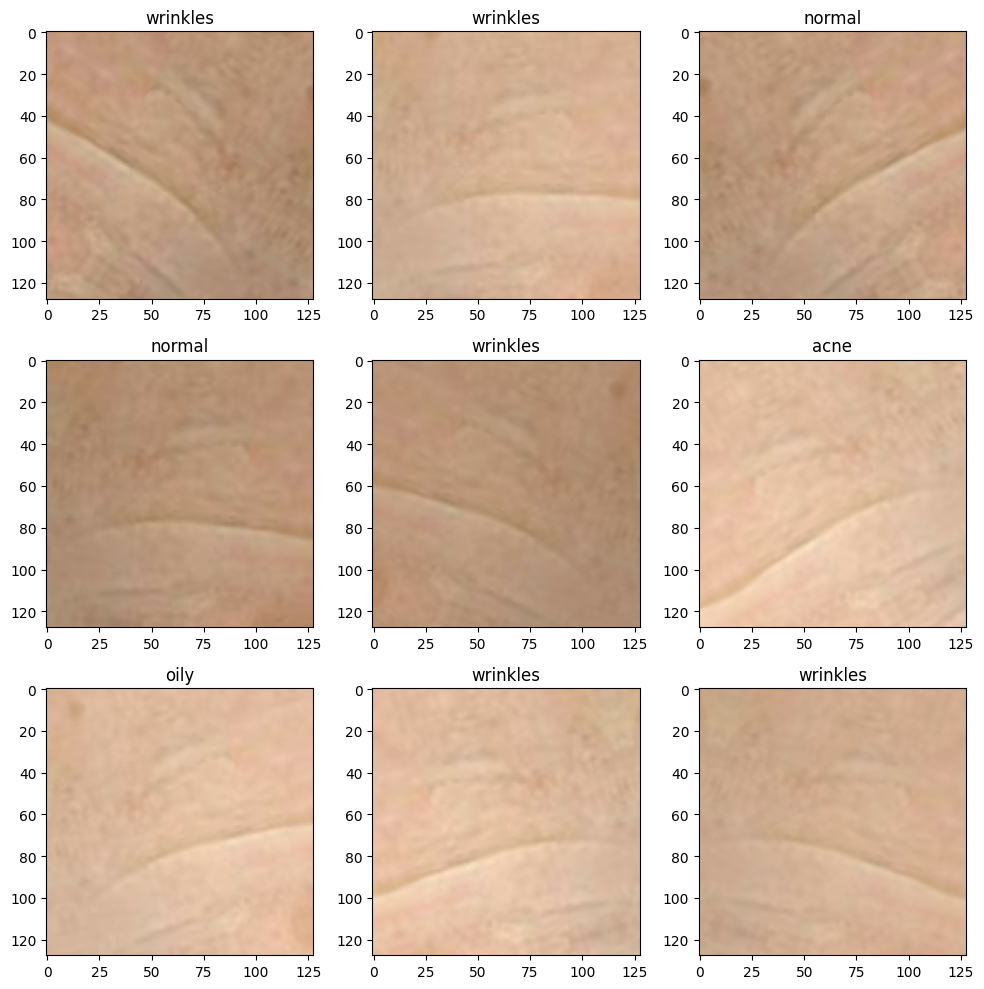

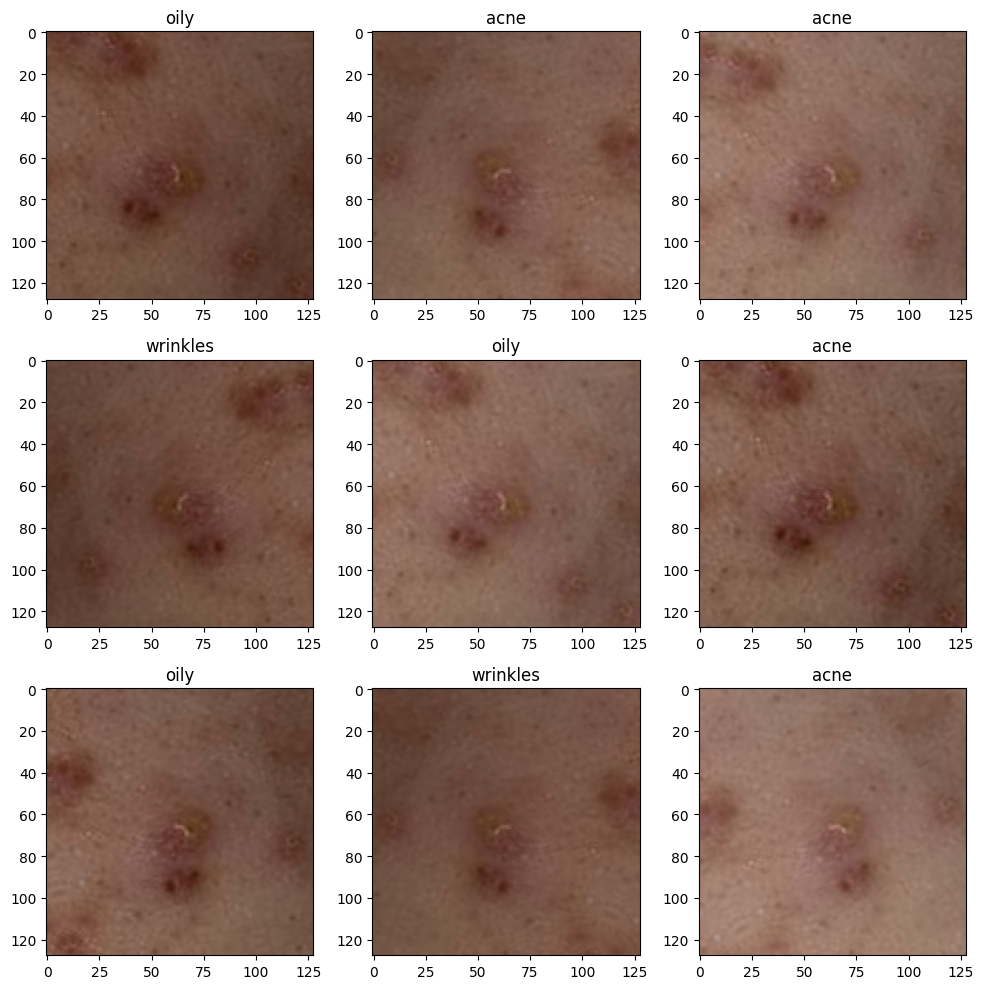

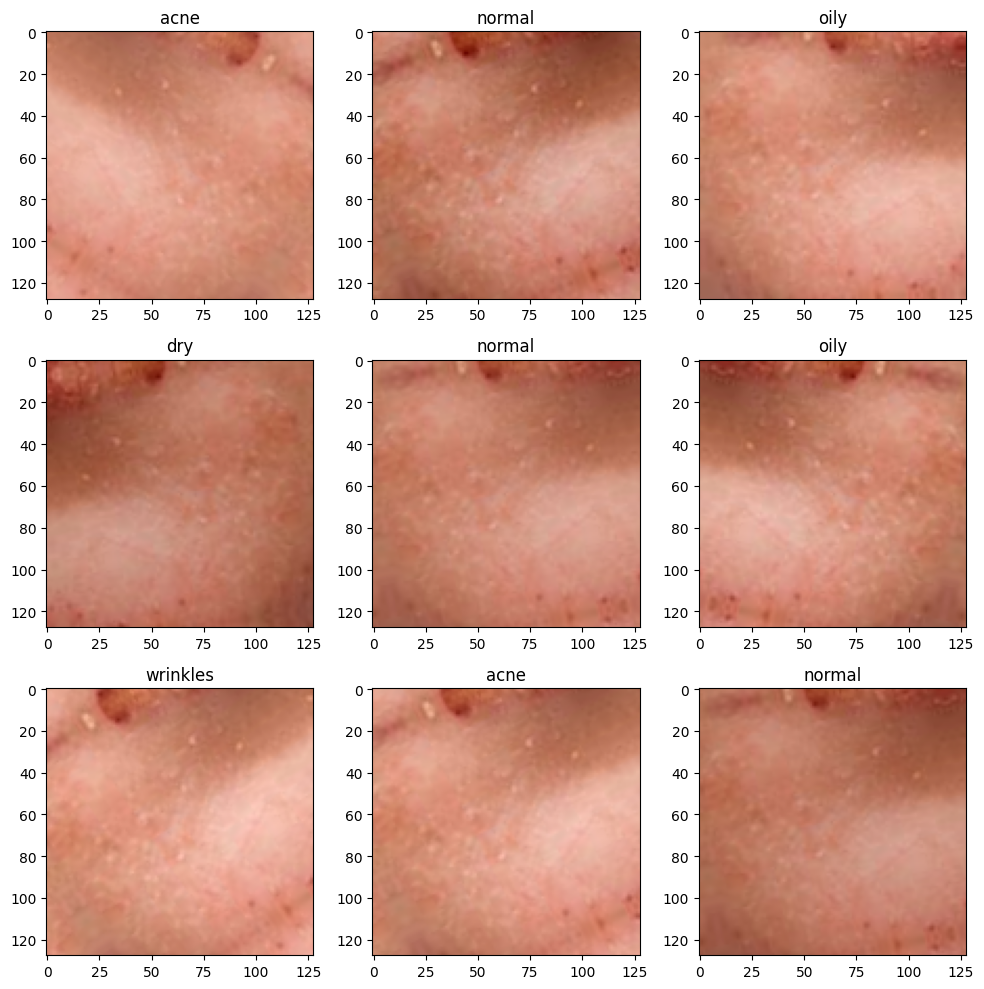

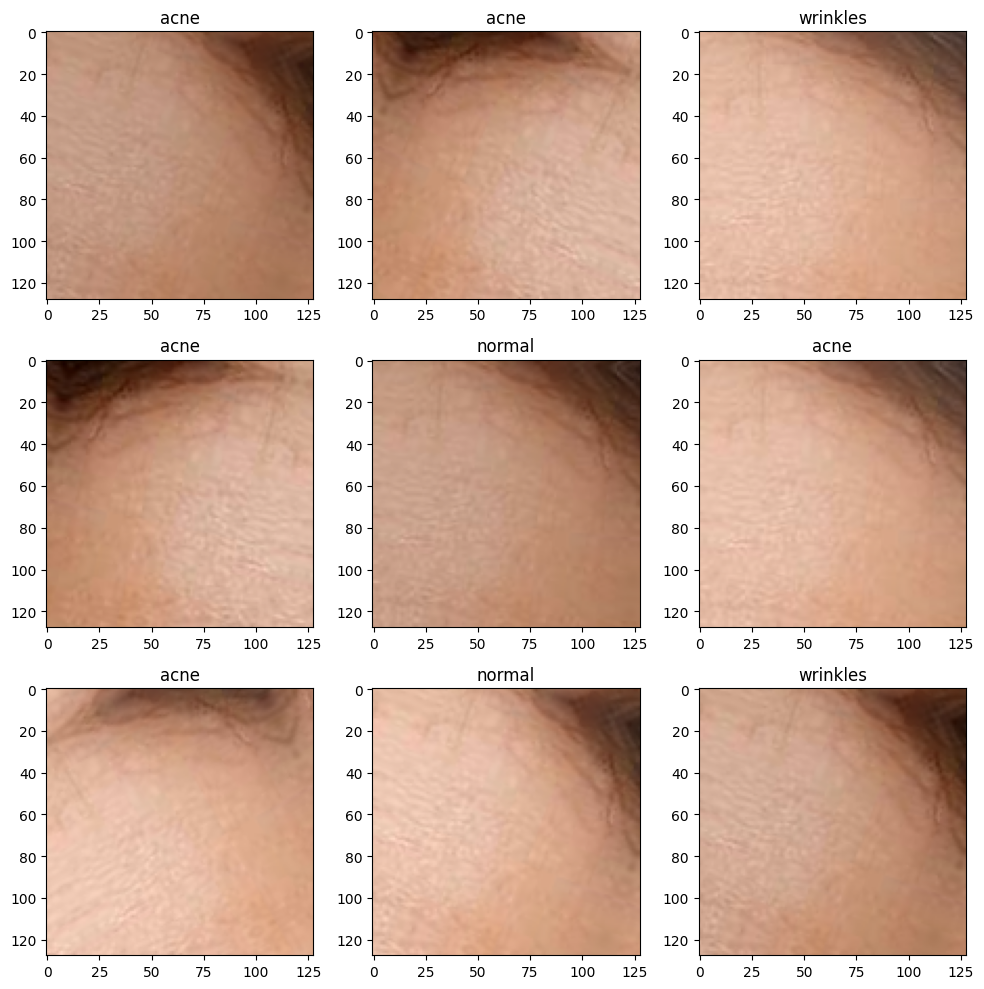

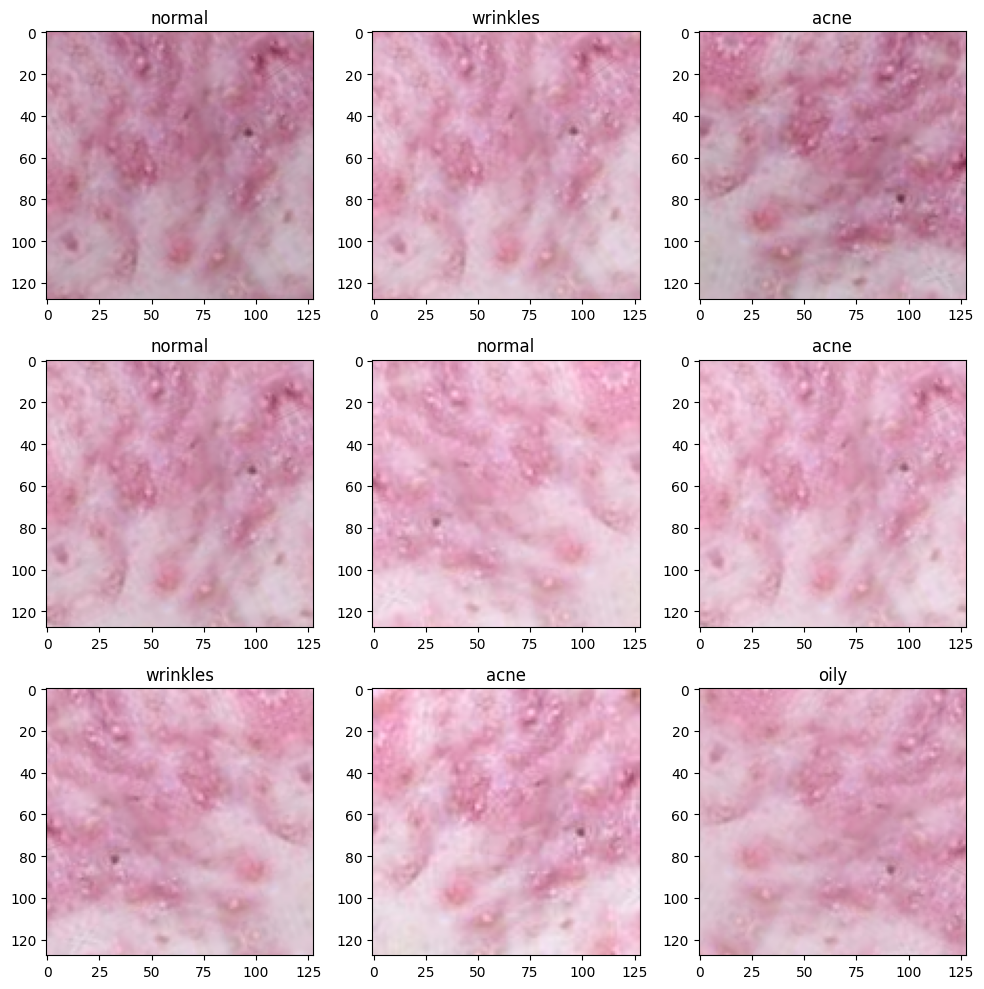

In [9]:
# Visualize the output from the applied filters
num_pics = 6
sel_branch = 6
num_rows = 3
num_cols = 3
for k in range(num_pics):
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(sel_branch):
        for i in range(num_rows*num_cols):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(augmented_images[k].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.tight_layout()

## Pretrained models in Literature
In the literature we have seen the following models used:
* 2x (Conv + MaxPooling) layers in https://ieeexplore.ieee.org/document/9580174
* ResNet 152 model in https://arxiv.org/ftp/arxiv/papers/1907/1907.07901.pdf
* AlexNet (5x Conv with some MaxPooling layers in between some layers) in https://www.sciencedirect.com/science/article/pii/S1877050919321295?via%3Dihub
* GoogleNet (22 layers deep) (trained on ImageNet dataset) using transfer-learning process in https://link.springer.com/chapter/10.1007/978-981-15-2188-1_14
* Custom model (2x (Conv + MaxPooling)) with final Dense layer of shape 7 due to 7 classes in https://www.nature.com/articles/s41598-018-24204-6
* Also used VGG16 model in https://www.nature.com/articles/s41598-018-24204-6
* GoogleNet in https://link-springer-com.ezproxy.lib.gla.ac.uk/chapter/10.1007/978-3-319-59876-5_53
* ResNet50 and ResNet 152 in https://www.frontiersin.org/articles/10.3389/fmed.2021.644327/full
* MobileNet has been used in Dragomir https://ieeexplore.ieee.org/document/9301064

## Pretrained models available in Keras
https://keras.io/api/applications/


# Creating custom model with Keras layers

Guide for adding preprocessing layers to `keras.application`, i.e. pre-defined model:
https://www.tensorflow.org/guide/keras/preprocessing_layers


In [10]:
# Data Augmentation layer can take place as a model layer (synchronous)
# or to the dataset (asynchronously) before being passed to the model
# The synchronous option benefits from GPU acceleration, however it will be slower when run on a CPU
# The asynchronous option is better if we are training on a CPU
from enum import Enum

class ModelType(Enum):
    CustomModel = 0
    MobileNet = 1
    ResNet50 = 2
    ResNet152 = 3
    VGG16 = 4
    Xception = 5


def build_model(image_size, num_classes, model_type):
    
    in_w = image_size[0]
    in_h = image_size[1]
    
    # When input data size is variable
    inputs = tf.keras.Input(shape=(in_w, in_h, 3))
    # x = tf.keras.layers.CenterCrop(height=200, width=200)(inputs)
    # If synchronous, add data augmentation layer as part of the model
    if(SYNCHRONOUS_AUGM):
        x = data_augmentation(inputs)
        # Scaling Layer (scales data into 0.0 - 1.0 range)
        x = tf.keras.layers.Rescaling(scale=1.0 / 255)(x)
    else:
        # Scaling Layer (scales data into 0.0 - 1.0 range)
        x = tf.keras.layers.Rescaling(scale=1.0 / 255)(inputs)
    
    if model_type == ModelType.CustomModel:
        
        
        # ----------- Add Model Layers here ---------------
        # Here layers are added randomly as example. See main guide.
            
        # Apply some convolution and pooling layers
        x = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        # Apply global average pooling to get flat feature vectors
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        # -------------------------------------------------
        
        
        # Dropout layer helps prevent overfitting by setting one input to 0 randomly
        # arguement is float from 0-1, fraction of the input units to drop.
        x = tf.keras.layers.Dropout(0.1)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    
    elif model_type == ModelType.ResNet152:
        # Following preprocess_input() method is required by ResNet
        # See https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/ResNet152V2
        
        x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
        x = tf.keras.layers.Dropout(0.1)(x)
        outputs = tf.keras.applications.ResNet152V2(
            include_top=True,
            weights=None,
            input_tensor=None,
            input_shape=(in_w, in_h, 3),
            pooling="avg",
            classes=num_classes,
            classifier_activation="softmax")(x)
        
    
    return tf.keras.Model(inputs, outputs)
    

model = build_model(rescale_image_size, len(class_names), ModelType.ResNet152)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 3)       0         
                                                                 
 resnet152v2 (Functional)    (None, 5)                 58341893  
                                                                 
Total params: 58,341,893
Trainable params: 58,198,149
Non-tra

## Callbacks to have checkpoints of model during training

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Adding callbacks to store the model while it is being trained.
# Models is saved at the start and end of each batch and epoch
model_path = "./model/"

checkpoint_path = model_path + 'model_chp'
google_drive_path = "/content/drive/MyDrive/Colab Notebooks/normalised_ds_model/model_chp"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath= google_drive_path,
        save_freq='epoch',
        save_weights_only=False,
        save_best_only = True)
]

# Train Model
* Training done with `fit()` method.
* Before calling `fit()`, need to set an **optimizer** and a **loss function** 

Good explanation and example
https://www.tensorflow.org/tutorials/images/classification

In [13]:
# If asynchronous, train the dataset before passing to the model
# If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.
# See Image Classification example linked at the top of Notebook
if(not SYNCHRONOUS_AUGM):
    # Might need to use image data generate class so that the augmented images are kept
    augmented_train_ds = train_ds.map(
        lambda x, y: (data_augmentation(x, training=True), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# --------- Specify Optimizer and Loss function ---------
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

# Save the weights using the `checkpoint_path` format
# model.save_weights(google_drive_path.format(epoch=0))


In [ ]:
import os

print(os.listdir("/content/drive/MyDrive/Colab Notebooks/model_epoch_17/"))

model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/model_epoch_17/")

['saved_model.pb', 'keras_metadata.pb', 'fingerprint.pb', 'variables', 'assets']


In [ ]:
# Re-evaluate the model
loss, acc = model.evaluate(val_ds)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

20/20 [==============================] - 5s 225ms/step - loss: 0.9424 - acc: 0.8301
Restored model, accuracy: 83.01%


In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/trained_model_final/trained_model_120_epoch")

In [14]:
# --------- Continue Training model if loaded -------------
epochs = 100
# steps_per_epoch = 2
history = model.fit(
    train_ds,
    epochs=epochs,
    # steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 1.9575 - acc: 0.2911

29/29 [==============================] - 222s 4s/step - loss: 1.9575 - acc: 0.2911 - val_loss: 1.5769 - val_acc: 0.2768
Epoch 2/100
29/29 [==============================] - 6s 186ms/step - loss: 1.5096 - acc: 0.4000 - val_loss: 1.7175 - val_acc: 0.2768
Epoch 3/100
29/29 [==============================] - ETA: 0s - loss: 1.4774 - acc: 0.4044

29/29 [==============================] - 96s 3s/step - loss: 1.4774 - acc: 0.4044 - val_loss: 1.5728 - val_acc: 0.3214
Epoch 4/100
29/29 [==============================] - 5s 185ms/step - loss: 1.4606 - acc: 0.3978 - val_loss: 1.5983 - val_acc: 0.3929
Epoch 5/100
29/29 [==============================] - 6s 200ms/step - loss: 1.3889 - acc: 0.4578 - val_loss: 2.0240 - val_acc: 0.3036
Epoch 6/100
29/29 [==============================] - 5s 185ms/step - loss: 1.3932 - acc: 0.4533 - val_loss: 2.4198 - val_acc: 0.2946
Epoch 7/100
29/29 [==============================] - 5s 184ms/step - loss: 1.3099 - acc: 0.5133 - val_loss: 1.9185 - val_acc: 0.3214
Epoch 8/100
29/29 [==============================] - 5s 181ms/step - loss: 1.3545 - acc: 0.4600 - val_loss: 2.1743 - val_acc: 0.2857
Epoch 9/100
29/29 [==============================] - 5s 188ms/step - loss: 1.2399 - acc: 0.4933 - val_loss: 2.8115 - val_acc: 0.3214
Epoch 10/100
29/29 [==============================] - 5s 179ms/step - loss: 1.2766 

29/29 [==============================] - 94s 3s/step - loss: 1.1699 - acc: 0.5600 - val_loss: 1.5207 - val_acc: 0.4554
Epoch 17/100
29/29 [==============================] - 6s 189ms/step - loss: 1.1717 - acc: 0.5244 - val_loss: 137.2660 - val_acc: 0.2946
Epoch 18/100
29/29 [==============================] - 6s 194ms/step - loss: 1.1709 - acc: 0.5600 - val_loss: 32.9153 - val_acc: 0.4464
Epoch 19/100
29/29 [==============================] - 5s 188ms/step - loss: 1.2321 - acc: 0.5089 - val_loss: 2.1892 - val_acc: 0.4911
Epoch 20/100
29/29 [==============================] - ETA: 0s - loss: 1.1792 - acc: 0.5644

29/29 [==============================] - 98s 4s/step - loss: 1.1792 - acc: 0.5644 - val_loss: 1.4205 - val_acc: 0.5268
Epoch 21/100
29/29 [==============================] - 6s 189ms/step - loss: 1.1620 - acc: 0.5622 - val_loss: 2.8813 - val_acc: 0.4643
Epoch 22/100
29/29 [==============================] - 6s 199ms/step - loss: 1.1892 - acc: 0.5444 - val_loss: 3.1542 - val_acc: 0.3929
Epoch 23/100
29/29 [==============================] - 5s 183ms/step - loss: 1.2008 - acc: 0.5378 - val_loss: 1.8906 - val_acc: 0.5446
Epoch 24/100
29/29 [==============================] - 5s 187ms/step - loss: 1.0094 - acc: 0.6267 - val_loss: 1.8254 - val_acc: 0.4375
Epoch 25/100
29/29 [==============================] - ETA: 0s - loss: 1.1197 - acc: 0.5800

29/29 [==============================] - 95s 3s/step - loss: 1.1197 - acc: 0.5800 - val_loss: 1.1031 - val_acc: 0.6250
Epoch 26/100
29/29 [==============================] - 6s 193ms/step - loss: 1.0692 - acc: 0.6022 - val_loss: 1.4471 - val_acc: 0.5089
Epoch 27/100
29/29 [==============================] - 5s 185ms/step - loss: 1.1214 - acc: 0.5889 - val_loss: 3.6344 - val_acc: 0.3214
Epoch 28/100
29/29 [==============================] - 6s 204ms/step - loss: 1.0443 - acc: 0.6333 - val_loss: 3.2904 - val_acc: 0.6071
Epoch 29/100
29/29 [==============================] - 6s 197ms/step - loss: 1.0715 - acc: 0.5933 - val_loss: 8.6307 - val_acc: 0.4464
Epoch 30/100
29/29 [==============================] - 5s 185ms/step - loss: 1.0613 - acc: 0.5933 - val_loss: 2.6613 - val_acc: 0.4911
Epoch 31/100
29/29 [==============================] - 5s 181ms/step - loss: 0.9801 - acc: 0.6622 - val_loss: 1.7769 - val_acc: 0.4732
Epoch 32/100
29/29 [==============================] - 5s 188ms/step - loss: 1

29/29 [==============================] - 97s 3s/step - loss: 0.8631 - acc: 0.6822 - val_loss: 1.0251 - val_acc: 0.6250
Epoch 42/100
29/29 [==============================] - 6s 188ms/step - loss: 0.8228 - acc: 0.6933 - val_loss: 1.0794 - val_acc: 0.6250
Epoch 43/100
29/29 [==============================] - 6s 196ms/step - loss: 0.8921 - acc: 0.6956 - val_loss: 1.1146 - val_acc: 0.6161
Epoch 44/100
29/29 [==============================] - 5s 182ms/step - loss: 0.9271 - acc: 0.6689 - val_loss: 17.0923 - val_acc: 0.3393
Epoch 45/100
29/29 [==============================] - 6s 197ms/step - loss: 0.7828 - acc: 0.7156 - val_loss: 1.7369 - val_acc: 0.5179
Epoch 46/100
29/29 [==============================] - 5s 181ms/step - loss: 0.8395 - acc: 0.7067 - val_loss: 1.3326 - val_acc: 0.5446
Epoch 47/100
29/29 [==============================] - 5s 179ms/step - loss: 0.8141 - acc: 0.7089 - val_loss: 2.0590 - val_acc: 0.5268
Epoch 48/100
29/29 [==============================] - 6s 197ms/step - loss: 

29/29 [==============================] - 96s 3s/step - loss: 0.6879 - acc: 0.7556 - val_loss: 0.8775 - val_acc: 0.7143
Epoch 70/100
29/29 [==============================] - 6s 187ms/step - loss: 0.8566 - acc: 0.7200 - val_loss: 1.0232 - val_acc: 0.5982
Epoch 71/100
29/29 [==============================] - 6s 194ms/step - loss: 0.8451 - acc: 0.7000 - val_loss: 2.2782 - val_acc: 0.5804
Epoch 72/100
29/29 [==============================] - 6s 201ms/step - loss: 0.6362 - acc: 0.7978 - val_loss: 1.2980 - val_acc: 0.5893
Epoch 73/100
29/29 [==============================] - 6s 208ms/step - loss: 0.5726 - acc: 0.7822 - val_loss: 0.9536 - val_acc: 0.6518
Epoch 74/100
29/29 [==============================] - 5s 182ms/step - loss: 0.5298 - acc: 0.8089 - val_loss: 1.0010 - val_acc: 0.7054
Epoch 75/100
29/29 [==============================] - 5s 180ms/step - loss: 0.6674 - acc: 0.7711 - val_loss: 1.1888 - val_acc: 0.6161
Epoch 76/100
29/29 [==============================] - 5s 188ms/step - loss: 0

29/29 [==============================] - 97s 3s/step - loss: 0.3242 - acc: 0.8933 - val_loss: 0.8092 - val_acc: 0.6964
Epoch 85/100
29/29 [==============================] - ETA: 0s - loss: 0.4563 - acc: 0.8444

29/29 [==============================] - 97s 3s/step - loss: 0.4563 - acc: 0.8444 - val_loss: 0.7304 - val_acc: 0.7232
Epoch 86/100
29/29 [==============================] - 5s 181ms/step - loss: 0.6146 - acc: 0.7889 - val_loss: 2.6399 - val_acc: 0.4554
Epoch 87/100
29/29 [==============================] - 6s 205ms/step - loss: 0.4138 - acc: 0.8556 - val_loss: 1.3169 - val_acc: 0.5625
Epoch 88/100
29/29 [==============================] - 6s 192ms/step - loss: 0.4132 - acc: 0.8622 - val_loss: 1.0425 - val_acc: 0.6518
Epoch 89/100
29/29 [==============================] - 6s 209ms/step - loss: 0.3152 - acc: 0.8689 - val_loss: 1.0973 - val_acc: 0.6964
Epoch 90/100
29/29 [==============================] - 5s 180ms/step - loss: 0.3321 - acc: 0.8867 - val_loss: 1.3240 - val_acc: 0.6429
Epoch 91/100
29/29 [==============================] - 5s 185ms/step - loss: 0.4270 - acc: 0.8378 - val_loss: 1.2628 - val_acc: 0.6518
Epoch 92/100
29/29 [==============================] - 6s 192ms/step - loss: 0

# Visualisation of Performance

In [16]:
# --------- Continue Training model -------------
epochs = 50
# steps_per_epoch = 2
history2 = model.fit(
    train_ds,
    epochs=epochs,
    # steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50
29/29 [==============================] - 5s 179ms/step - loss: 0.3611 - acc: 0.8711 - val_loss: 0.9487 - val_acc: 0.7768
Epoch 2/50
29/29 [==============================] - 6s 198ms/step - loss: 0.2529 - acc: 0.9244 - val_loss: 1.1675 - val_acc: 0.6964
Epoch 3/50
29/29 [==============================] - 6s 187ms/step - loss: 0.1918 - acc: 0.9289 - val_loss: 1.0735 - val_acc: 0.6964
Epoch 4/50
29/29 [==============================] - 6s 192ms/step - loss: 0.4374 - acc: 0.8600 - val_loss: 1.4925 - val_acc: 0.6518
Epoch 5/50
29/29 [==============================] - 5s 187ms/step - loss: 0.3983 - acc: 0.8689 - val_loss: 1.3528 - val_acc: 0.6607
Epoch 6/50
29/29 [==============================] - 6s 195ms/step - loss: 0.2177 - acc: 0.9178 - val_loss: 1.0914 - val_acc: 0.7054
Epoch 7/50
29/29 [==============================] - 5s 180ms/step - loss: 0.2646 - acc: 0.9267 - val_loss: 1.4303 - val_acc: 0.6875
Epoch 8/50
29/29 [==============================] - 6s 190ms/step - loss: 0.

In [19]:
# --------- Continue Training model -------------
epochs = 100
# steps_per_epoch = 2
history3 = model.fit(
    train_ds,
    epochs=epochs,
    # steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/100
29/29 [==============================] - 5s 185ms/step - loss: 0.2029 - acc: 0.9267 - val_loss: 2.7837 - val_acc: 0.5625
Epoch 2/100
29/29 [==============================] - 5s 182ms/step - loss: 0.2924 - acc: 0.9133 - val_loss: 2.5922 - val_acc: 0.6339
Epoch 3/100
29/29 [==============================] - 5s 184ms/step - loss: 0.4091 - acc: 0.8622 - val_loss: 1.6158 - val_acc: 0.7232
Epoch 4/100
29/29 [==============================] - 6s 196ms/step - loss: 0.2147 - acc: 0.9244 - val_loss: 1.0293 - val_acc: 0.7679
Epoch 5/100
29/29 [==============================] - 6s 198ms/step - loss: 0.1520 - acc: 0.9556 - val_loss: 0.9857 - val_acc: 0.7232
Epoch 6/100
29/29 [==============================] - 6s 192ms/step - loss: 0.1552 - acc: 0.9578 - val_loss: 1.8987 - val_acc: 0.6071
Epoch 7/100
29/29 [==============================] - 5s 185ms/step - loss: 0.0873 - acc: 0.9711 - val_loss: 1.4215 - val_acc: 0.5893
Epoch 8/100
29/29 [==============================] - 5s 179ms/step - 

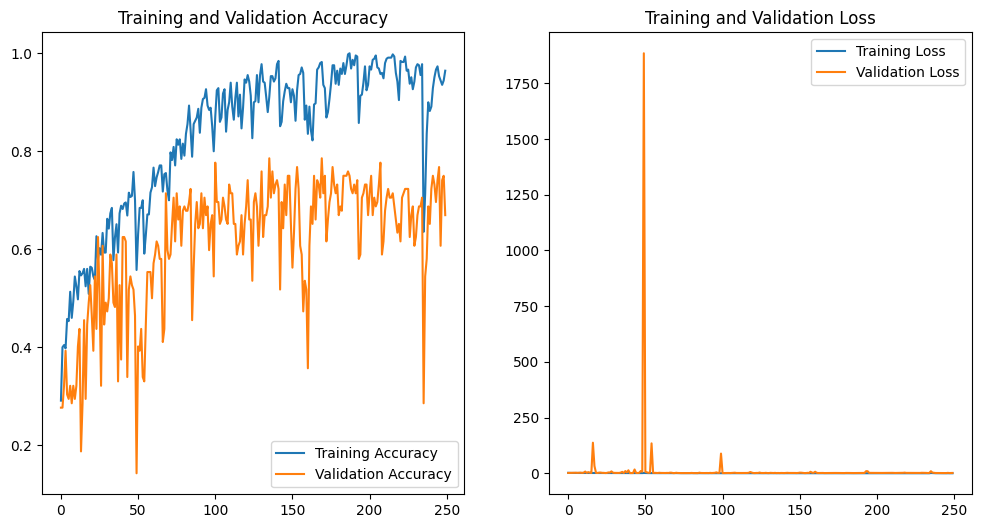

In [22]:
acc = np.append(history.history['acc'], history2.history['acc'])
acc = np.append(acc, history3.history['acc'])
val_acc = np.append(history.history['val_acc'], history2.history['val_acc'])
val_acc = np.append(val_acc, history3.history['val_acc'])

loss = np.append(history.history['loss'], history2.history['loss'])
loss = np.append(loss, history3.history['loss'])

val_loss = np.append(history.history['val_loss'], history2.history['val_loss'])
val_loss = np.append(val_loss, history3.history['val_loss'])

epochs_range = range(250)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Load pre-stored model and continue training

In [ ]:
# !zip -r /content/CNN_development/todownload.zip /content/CNN_development/model/model_epoch_17

from google.colab import files
files.download("/content/CNN_development/todownload.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cd model

# Evaluate the model on validation data when training is done

In [24]:
loss, acc = model.evaluate(val_ds)  # returns loss and metrics
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)

7/7 [==============================] - 1s 70ms/step - loss: 1.5389 - acc: 0.6696
loss: 1.54
acc: 0.67


# Run Inference on data

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    # "00 - Datasets split by class - Watermark Removed/01 - Acne/07RosaceaFulFAcepart_2.jpg", target_size=rescale_image_size
    # "/content/guy with acne.jpg", target_size=rescale_image_size
    "/content/me regular portrait.jpg", target_size=rescale_image_size

)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions[0])
score = predictions[0]
print(f"This image is\n {100 * score[0]:.2f}% Acne,\n {100 * score[1]:.2f}% Wrinkles, \
      \n {100 * score[2]:.2f}% Dry skin,\n {100 * score[3]:.2f}% Normal skin,\n {100 * score[4]:.2f}% Oily skin.")

1/1 [==============================] - 0s 41ms/step
[9.9949360e-01 3.4485055e-07 1.8971087e-04 1.4177788e-15 3.1630590e-04]
This image is
 99.95% Acne,
 0.00% Wrinkles,       
 0.02% Dry skin,
 0.00% Normal skin,
 0.03% Oily skin.


# Finding the best model configuration with hyperparameter tuning

In [ ]:
# Put model in a function
# Use hp argument (hyperparameter) in any parameter to tell Keras to tune it
def build_model(hp):
    inputs = tf.keras.Input(shape=(784,))
    x = tf.keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
import keras_tuner

tuner = keras_tuner.tuners.Hyperband(
  build_model,
  objective='val_loss',
  max_epochs=100,
  max_trials=200,
  executions_per_trial=2,
  directory='my_dir')

# MNIST model example

In [ ]:
# Get the data as Numpy arrays
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Build a simple model
inputs = tf.keras.Input(shape=(28, 28))
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")